In [1]:
import pandas as pd
import numpy as np
import re
import string
from datetime import datetime
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import concatenate
from keras.layers import Multiply
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

Using TensorFlow backend.


In [2]:
df_ratings=pd.read_csv('ratings.csv')

In [3]:
df_ratings.shape

(100836, 4)

In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# sort df by timestamp 
df_ratings = df_ratings.sort_values('timestamp')

In [6]:
# encode
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

user_ids = user_encoder.fit_transform(df_ratings.userId)
movie_ids = movie_encoder.fit_transform(df_ratings.movieId)

In [7]:
# split dataset
num_train = int(len(user_ids) * 0.8)
train_user_ids = user_ids[:num_train]
train_movie_ids = movie_ids[:num_train]
train_ratings = df_ratings.rating.values[:num_train]
val_user_ids = user_ids[num_train:]
val_movie_ids = movie_ids[num_train:]
val_ratings = df_ratings.rating.values[num_train:]

In [8]:
num_users= user_ids.max()+1
num_movies = movie_ids.max() + 1

In [9]:
# ratings normalization
train_ratings /= 5
val_ratings /= 5

### Define model

In [10]:
def define_model():
    user_inp = Input((1,))
    user_hidden = Embedding(input_dim=num_users, output_dim=64)(user_inp)
    user_hidden = Flatten()(user_hidden)
    
    item_inp = Input((1,))
    item_hidden = Embedding(input_dim=num_movies, output_dim=64)(item_inp)
    item_hidden = Flatten()(item_hidden)
    
    # element-wise multiplication
    mf_output = Multiply()([user_hidden, item_hidden])
    
    hidden = concatenate([user_hidden, item_hidden])
    hidden = Dense(128, activation='relu')(hidden)
    hidden = Dropout(0.2)(hidden)
    mlp_output = Dense(64, activation='relu')(hidden)    

    
    output = concatenate([mf_output, mlp_output])
    output = Dense(1, activation='sigmoid')(output)
    
    model = Model(inputs=[user_inp, item_inp], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='neural_col.png')
    return model

In [11]:
model = define_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        39040       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        622336      input_2[0][0]                    
____________________________________________________________________________________________

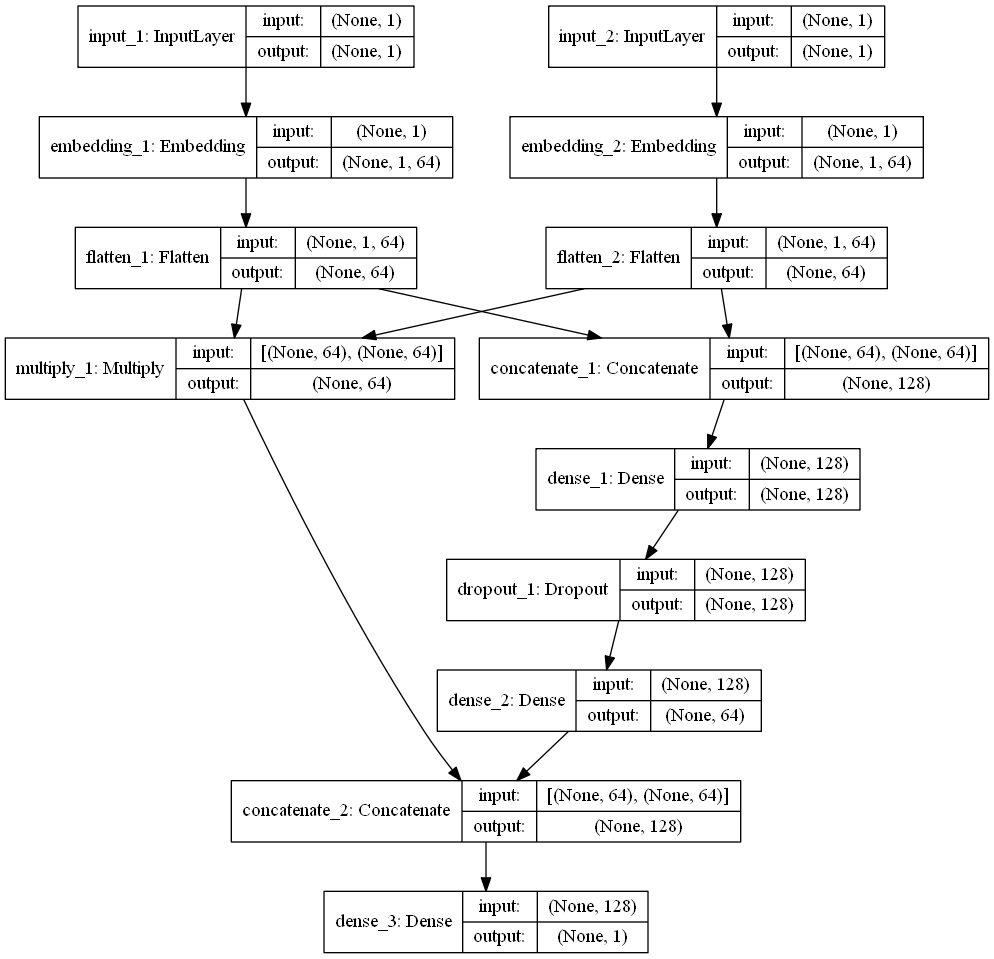

In [12]:
Image('neural_col.png', width= 680, height=512)

### Train

In [13]:
# Train 
model.fit([train_user_ids, train_movie_ids], train_ratings,\
          validation_data=([val_user_ids, val_movie_ids], val_ratings), epochs=10, batch_size=128)

C:\Users\Mi\anaconda3\envs\env_nlpgpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80668 samples, validate on 20168 samples
Epoch 1/10
80668/80668 [==============================] - 6s 76us/step - loss: 0.0339 - val_loss: 0.0418
Epoch 2/10
80668/80668 [==============================] - 6s 71us/step - loss: 0.0280 - val_loss: 0.0412
Epoch 3/10
80668/80668 [==============================] - 6s 71us/step - loss: 0.0258 - val_loss: 0.0422
Epoch 4/10
80668/80668 [==============================] - 6s 70us/step - loss: 0.0236 - val_loss: 0.0428
Epoch 5/10
80668/80668 [==============================] - 6s 70us/step - loss: 0.0212 - val_loss: 0.0459
Epoch 6/10
80668/80668 [==============================] - 6s 70us/step - loss: 0.0189 - val_loss: 0.0502
Epoch 7/10
80668/80668 [==============================] - 6s 70us/step - loss: 0.0168 - val_loss: 0.0566
Epoch 8/10
80668/80668 [==============================] - 6s 71us/step - loss: 0.0152 - val_loss: 0.0595
Epoch 9/10
80668/80668 [==============================] - 6s 72us/step - loss: 0.0140 - val_loss: 0.0620
Epoch

### Evaluation

In [14]:
def dcg_at_k(r, k):
    '''
    Compute DCG
    args:
        r: np.array, to be evaluated
        k: int, number of entries to be considered
    
    returns:
        dcg: float, computed dcg
        
    '''
    r = r[:k]
    dcg = np.sum(r / np.log2(np.arange(2, len(r) + 2)))
    return dcg

In [15]:
def ndcg_at_k(r, k, method=0):
    '''
    Compute NDCG
    args:
        r: np.array, to be evaluated
        k: int, number of entries to be considered
    
    returns:
        dcg: float, computed ndcg
        
    '''
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)

    return dcg_at_k(r, k) / dcg_max

In [16]:
def evaluate_prediction(predictions):
    '''
    Return the average ndcg for each users
    args:
        predictions: np.array user-item predictions
    returns:
        ndcg: float, computed NDCG
    '''
    ndcgs = []
    for target_user in np.unique(val_user_ids):
        # get movie ids and ratings associated with the target user.
        target_val_movie_ids = val_movie_ids[val_user_ids == target_user] 
        target_val_ratings = val_ratings[val_user_ids == target_user] 
        
        # compute ndcg for this user
        ndcg = ndcg_at_k(target_val_ratings[np.argsort(-predictions[val_user_ids == target_user])], k=30)
        ndcgs.append(ndcg)
    ndcg = np.mean(ndcgs)
    return ndcg

In [17]:
# prediction and evaluation
predictions = model.predict([val_user_ids, val_movie_ids])
evaluate_prediction(predictions[:,0])

0.8679954603584514

### Add features

In [18]:
df_movies = pd.read_csv('movies.csv')

In [19]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
df_movies.movieId.nunique()

9742

In [21]:
# merge datasets on movieId
df_feat = df_ratings.merge(right=df_movies, how='left', on='movieId')

In [22]:
df_feat.head(2)

,userId,movieId,rating,timestamp,title,genres
0,429,595,1.0,828124615,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
1,429,588,1.0,828124615,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical


In [23]:
# split tags in genres 
tags = [i.split("|") for i in df_feat["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['Action', 'Comedy', 'Sci-Fi', 'Drama', 'Musical', 'Animation', 'Western', 'Documentary', 'Film-Noir', 'Adventure', 'Mystery', 'War', 'IMAX', 'Children', 'Horror', 'Thriller', 'Romance', 'Crime', 'Fantasy']


In [24]:
# add binary column for each genre
for col in columns:
    df_feat[col] = df_feat["genres"].apply(lambda x: 1 if col in x else 0)
df_feat.head()

,userId,movieId,rating,timestamp,title,genres,Action,Comedy,Sci-Fi,Drama,...,Adventure,Mystery,War,IMAX,Children,Horror,Thriller,Romance,Crime,Fantasy
0,429,595,1.0,828124615,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1
1,429,588,1.0,828124615,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,429,590,1.0,828124615,Dances with Wolves (1990),Adventure|Drama|Western,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,429,592,1.0,828124615,Batman (1989),Action|Crime|Thriller,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,429,432,0.6,828124615,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
# Split datasets
val_feat = df_feat[num_train:]
val_feat = val_feat[columns]
val_feat.shape

(20168, 19)

In [26]:
val_feat = val_feat.to_numpy()

In [27]:
train_feat = df_feat[:num_train][columns]
train_feat.shape

(80668, 19)

In [28]:
train_feat = df_feat[:num_train][columns]
train_user_ids = user_ids[:num_train]
train_movie_ids = movie_ids[:num_train]
train_ratings = df_ratings.rating.values[:num_train]

In [29]:
feat=19

In [30]:
from keras import regularizers

In [31]:
def define_model2():
    user_inp = Input((1,))
    user_hidden = Embedding(input_dim=num_users, output_dim=64)(user_inp)
    user_hidden = Flatten()(user_hidden)
    
    item_inp = Input((1,))
    item_hidden = Embedding(input_dim=num_movies, output_dim=64)(item_inp)
    item_hidden = Flatten()(item_hidden)
    
    # element-wise multiplication
    mf_output = Multiply()([user_hidden, item_hidden])
    
    hidden = concatenate([user_hidden, item_hidden])
    hidden = Dense(128, activation='relu')(hidden)
    hidden = Dropout(0.2)(hidden)
    mlp_output = Dense(64, activation='relu')(hidden)
    
    # features
    feat_inp = Input(shape=(feat,))
    feat_hidden = Dense(units=feat, activation='relu', kernel_regularizer=regularizers.l2(0.1))(feat_inp)
    feat_hidden = Dropout(0.5)(feat_hidden)

    
    output = concatenate([mf_output, mlp_output, feat_hidden])
    output = Dense(1, activation='sigmoid')(output)
    
    model = Model(inputs=[user_inp, item_inp, feat_inp], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='neural_feat.png')
    return model

In [32]:
model2 = define_model2()
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 64)        39040       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 64)        622336      input_4[0][0]                    
____________________________________________________________________________________________

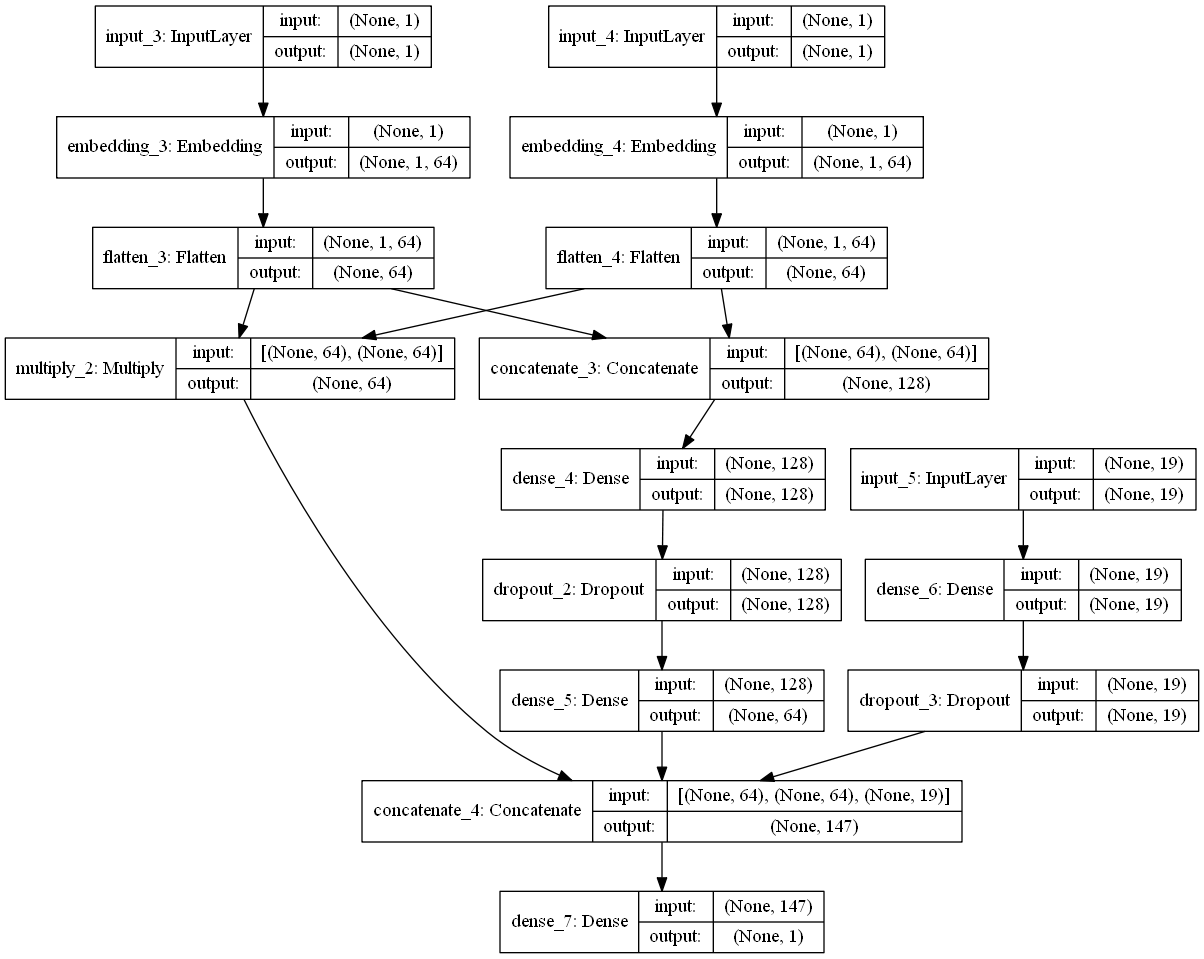

In [33]:
Image('neural_feat.png', width= 680, height=512)

In [34]:
model2.fit([train_user_ids, train_movie_ids, train_feat], train_ratings,\
          validation_data=([val_user_ids, val_movie_ids, val_feat], val_ratings), epochs=5, batch_size=128)

C:\Users\Mi\anaconda3\envs\env_nlpgpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80668 samples, validate on 20168 samples
Epoch 1/5
80668/80668 [==============================] - 7s 82us/step - loss: 0.3881 - val_loss: 0.0442
Epoch 2/5
80668/80668 [==============================] - 6s 80us/step - loss: 0.0284 - val_loss: 0.0414
Epoch 3/5
80668/80668 [==============================] - 6s 79us/step - loss: 0.0260 - val_loss: 0.0418
Epoch 4/5
80668/80668 [==============================] - 6s 79us/step - loss: 0.0241 - val_loss: 0.0427
Epoch 5/5
80668/80668 [==============================] - 6s 79us/step - loss: 0.0219 - val_loss: 0.0454


In [35]:
# prediction and evaluation
predictions = model2.predict([val_user_ids, val_movie_ids, val_feat])
evaluate_prediction(predictions[:,0])

0.8722481604940866